<a href="https://colab.research.google.com/github/FaisalAhmed0/variational-autoencoder/blob/main/VAEs_reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
This is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al
'''

'\nThis is a reimplementation of the varitional auto encoder based on the original paper "Auto-Encoding Variational Bayes". by Kingma et.al\n'

# Imports, Setup, and Data preperation 

In [54]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
# set the batch size for pytorch data loader
batch_size = 100

In [57]:
# function to load MNIST dataset
def load_mnist(batch_size):
  mnist = MNIST("./", train=True, download=True, transform=transforms.Compose([
                                                                                transforms.ToTensor()]) )
  mnist_test = MNIST("./", train=False, download=True,  transform=transforms.Compose([
                                                                              transforms.ToTensor()]) )
  mnist_dataloader = DataLoader(mnist, batch_size=batch_size)
  mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size)
  return mnist_dataloader, mnist_test_dataloader

In [58]:
# function to load frey face dataset
def load_frey_face(batch_size):
  # download the data
  ! wget https://cs.nyu.edu/~roweis/data/frey_rawface.mat

  fileName = "frey_rawface.mat"
  frey_face_mat = loadmat(fileName) # load the mat file
  frey_face_input = torch.tensor( frey_face_mat['ff'].T.reshape(-1, 1, 28, 20))
  dummy_targets = torch.zeros(frey_face_input.shape[0])

  size = frey_face_input.shape[0]
  train_size = int(0.9 * size)
  frey_face = TensorDataset(frey_face_input[: train_size], dummy_targets[: train_size])
  frey_face_test = TensorDataset(frey_face_input[train_size: ], dummy_targets[train_size:])

  frey_face_dataloader = DataLoader(frey_face, batch_size=batch_size)
  frey_face_test_dataloader = DataLoader(frey_face_test, batch_size=batch_size)
  return frey_face_dataloader, frey_face_test_dataloader

In [59]:
# plot a batch of images as a grid.
def plot_grid(dataloader):
  images, _ = next(iter(dataloader))
  grid = make_grid(images, )
  plt.figure(figsize=(10, 10))
  plt.imshow(grid.permute(1, 2, 0))

In [60]:
# load the data
mnist, mnist_test = load_mnist(batch_size)
freyface, freyface_test = load_frey_face(batch_size)

--2021-08-18 14:26:33--  https://cs.nyu.edu/~roweis/data/frey_rawface.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100584 (1.0M) [text/plain]
Saving to: ‘frey_rawface.mat.1’

frey_rawface.mat.1  100%[===================>]   1.05M   831KB/s    in 1.3s    

2021-08-18 14:26:35 (831 KB/s) - ‘frey_rawface.mat.1’ saved [1100584/1100584]



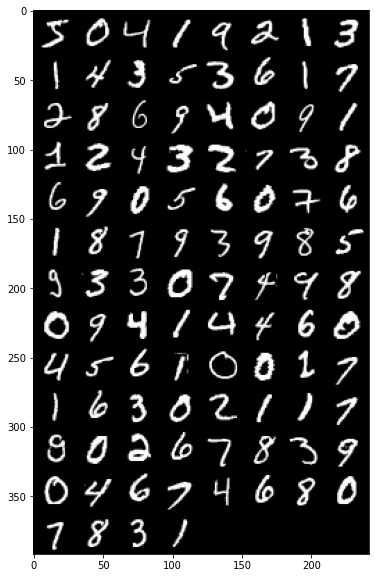

In [61]:
# plot a grid of images
plot_grid(mnist)

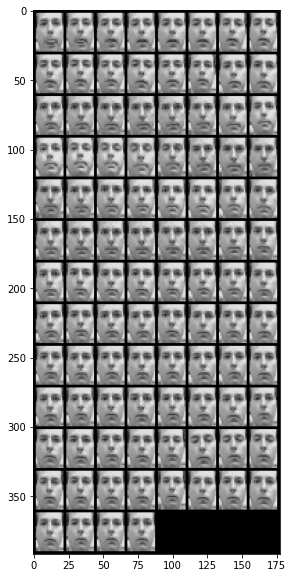

In [62]:
plot_grid(freyface)

# Model Architecture 

In [132]:
class Encoder(nn.Module):
  '''
  This class defines the encoder architecture
  '''
  def __init__(self, input_size, hidden_size, bottleneck):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.mean = nn.Linear(hidden_size, bottleneck)
    self.var = nn.Linear(hidden_size, bottleneck) 

    nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.mean.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.var.weight, mean=0.0, std=0.01)
    

  def forward(self, x):
    mean = self.mean(torch.tanh(self.linear1(x)))
    log_var =  self.var(torch.tanh(self.linear1(x)))
    return mean, log_var

In [133]:
class Decoder(nn.Module):
  '''
  This class defines the decoder architecture
  '''
  def __init__(self, bottleneck, hidden_size, input_size):
    super().__init__()
    self.linear1 = nn.Linear(bottleneck, hidden_size)
    self.mean = nn.Linear(hidden_size, input_size)

    nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
    nn.init.normal_(self.mean.weight, mean=0.0, std=0.01)

  def forward(self, x):
    mean = torch.sigmoid(self.mean(torch.tanh(self.linear1(x))))
    return mean

# Loss function and Training loop

In [161]:
def vae_loss(logvar_z, mean_z, output, target, size):
  # KL Divergence between the prior and the posterior
  kl_divergence = - 0.5 * (torch.sum(1 + logvar_z - mean_z.pow(2) - logvar_z.exp(), dim=1)).sum()
  # print(f"kl_divergence {kl_divergence}")
  # reconstruction loss
  reconstruction_loss = F.binary_cross_entropy(output, target, reduction='sum') 
  # print(f"reconstruction_loss: {reconstruction_loss}")
  loss = (size/batch_size) * (kl_divergence + reconstruction_loss)
  # print(f"loss {loss}")
  return loss

In [162]:
r = torch.ones(100, 700)
(r.sum(dim=1)).shape

torch.Size([100])

In [163]:
# simple function to implemenet the reparametrization trick
def reparametrization(mean, logv):
  eps = torch.randn_like(mean, device=device)
  z = mean + eps * logv.exp().pow(0.5)
  return z

In [164]:
def train(encoder, decoder, loss, optimizer, dataloader, epochs, channels=1, height=28, width=28, plot=True):
  losses = []
  dataset_size = len(dataloader) * batch_size
  for epoch in range(epochs):
    for img, _ in dataloader:
      img_flattend = img.reshape(-1, (torch.tensor(img.shape[1:])).prod())
      mu, logv = encoder(img_flattend.to(device))
      z = reparametrization(mu, logv)
      output = decoder(z.to(device))
      loss = vae_loss(logv.to(device), mu.to(device), output.to(device), img_flattend.to(device), dataset_size)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    losses.append(loss)
    print(f"Epoch: {epoch+1}, loss: {loss}")
    if (epoch+1) % 10 == 0 and plot:
      targets = img[:10]
      output_reshaped = output.reshape(-1, channels, height, width)[:10]
      target_grid = make_grid(targets.cpu().detach(), nrow=10)
      output_grid = make_grid(output_reshaped.cpu().detach(), nrow=10)
      plt.figure(figsize=(15, 10))
      plt.imshow(target_grid.permute(1, 2, 0))
      plt.figure(figsize=(15, 10))
      plt.imshow(output_grid.permute(1, 2, 0))
      plt.show()

# Test for the implementation

In [165]:
hidden_size = 500
bottleneck = 5
input_size = 784
stepsize = 0.01
epochs = 100
# add the parameters for weight initlization

Epoch: 1, loss: 10580746.0
Epoch: 2, loss: 9927749.0
Epoch: 3, loss: 9714478.0
Epoch: 4, loss: 9627498.0
Epoch: 5, loss: 9551332.0
Epoch: 6, loss: 9526004.0
Epoch: 7, loss: 9481488.0
Epoch: 8, loss: 9456675.0
Epoch: 9, loss: 9431915.0
Epoch: 10, loss: 9382481.0


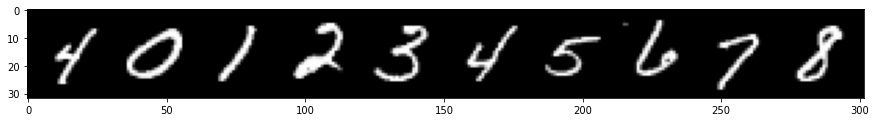

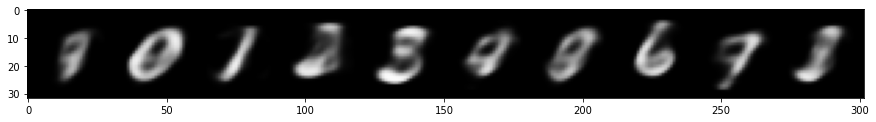

Epoch: 11, loss: 9350143.0
Epoch: 12, loss: 9279749.0
Epoch: 13, loss: 9266239.0
Epoch: 14, loss: 9208883.0
Epoch: 15, loss: 9175804.0
Epoch: 16, loss: 9128786.0
Epoch: 17, loss: 9117488.0
Epoch: 18, loss: 9051960.0
Epoch: 19, loss: 9023493.0
Epoch: 20, loss: 8959941.0


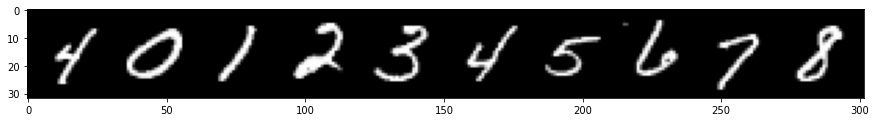

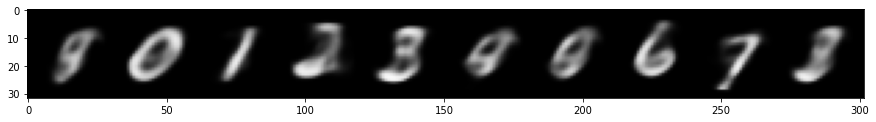

Epoch: 21, loss: 8932746.0
Epoch: 22, loss: 8901405.0
Epoch: 23, loss: 8861428.0
Epoch: 24, loss: 8834256.0
Epoch: 25, loss: 8802052.0
Epoch: 26, loss: 8760396.0
Epoch: 27, loss: 8731450.0
Epoch: 28, loss: 8685295.0
Epoch: 29, loss: 8648878.0
Epoch: 30, loss: 8634636.0


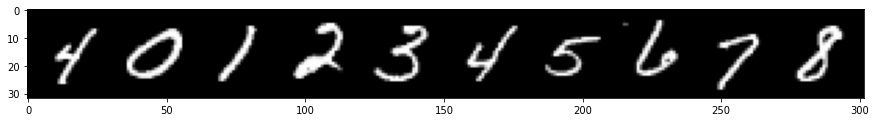

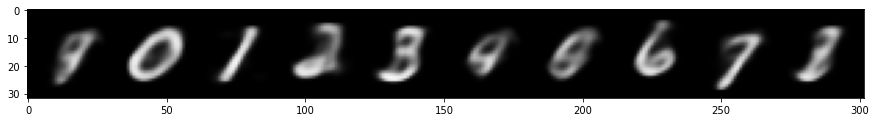

Epoch: 31, loss: 8588593.0
Epoch: 32, loss: 8586247.0
Epoch: 33, loss: 8541209.0
Epoch: 34, loss: 8497904.0
Epoch: 35, loss: 8488654.0
Epoch: 36, loss: 8462736.0
Epoch: 37, loss: 8438493.0
Epoch: 38, loss: 8409049.0
Epoch: 39, loss: 8411238.0
Epoch: 40, loss: 8398154.0


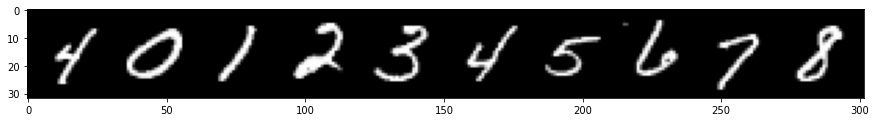

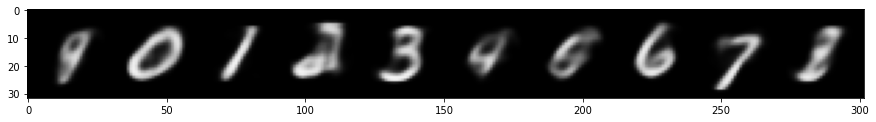

Epoch: 41, loss: 8377605.5
Epoch: 42, loss: 8351513.5
Epoch: 43, loss: 8303968.0
Epoch: 44, loss: 8325529.5
Epoch: 45, loss: 8310662.0
Epoch: 46, loss: 8312632.5
Epoch: 47, loss: 8247823.0
Epoch: 48, loss: 8251100.0
Epoch: 49, loss: 8253109.5
Epoch: 50, loss: 8214508.5


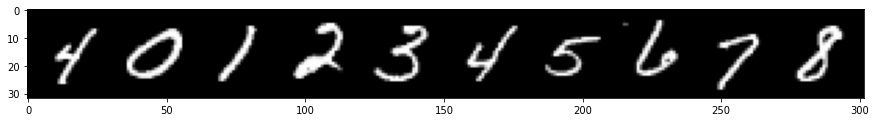

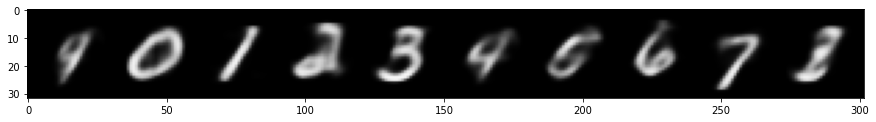

Epoch: 51, loss: 8238329.5
Epoch: 52, loss: 8218695.5
Epoch: 53, loss: 8192709.5
Epoch: 54, loss: 8158976.0
Epoch: 55, loss: 8171154.0
Epoch: 56, loss: 8151150.0
Epoch: 57, loss: 8168863.5
Epoch: 58, loss: 8139776.0
Epoch: 59, loss: 8131500.0
Epoch: 60, loss: 8142703.5


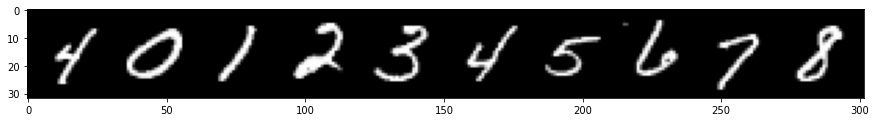

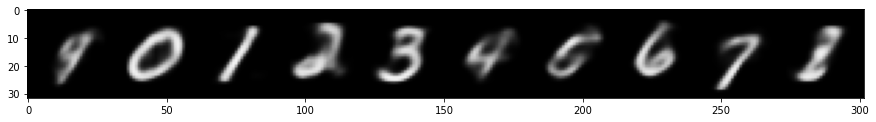

Epoch: 61, loss: 8093264.0
Epoch: 62, loss: 8120604.0
Epoch: 63, loss: 8104860.0
Epoch: 64, loss: 8079437.5
Epoch: 65, loss: 8086141.5
Epoch: 66, loss: 8069563.0
Epoch: 67, loss: 8076550.0
Epoch: 68, loss: 8057795.0
Epoch: 69, loss: 8039610.0
Epoch: 70, loss: 8041931.0


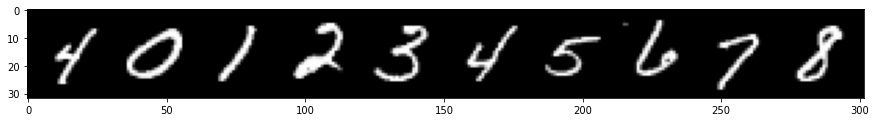

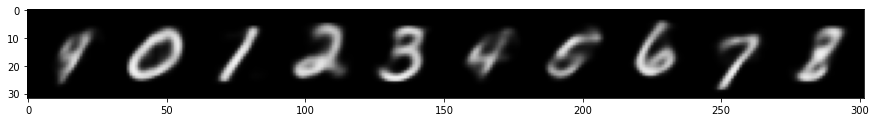

Epoch: 71, loss: 8026931.0
Epoch: 72, loss: 8029155.5
Epoch: 73, loss: 7998236.5
Epoch: 74, loss: 8025855.5
Epoch: 75, loss: 8015051.0
Epoch: 76, loss: 7989250.0
Epoch: 77, loss: 7982533.5
Epoch: 78, loss: 7958835.5
Epoch: 79, loss: 7971091.0
Epoch: 80, loss: 7962556.5


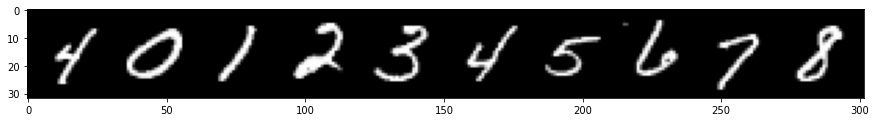

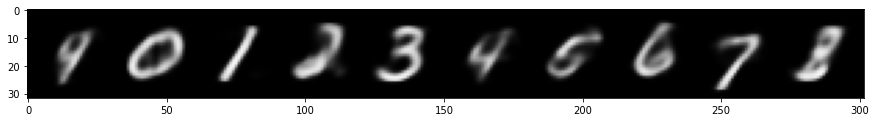

Epoch: 81, loss: 7942603.0
Epoch: 82, loss: 7949235.5
Epoch: 83, loss: 7940457.5
Epoch: 84, loss: 7937900.5
Epoch: 85, loss: 7935987.5
Epoch: 86, loss: 7951777.0
Epoch: 87, loss: 7916799.5
Epoch: 88, loss: 7921634.0
Epoch: 89, loss: 7901255.5
Epoch: 90, loss: 7902118.0


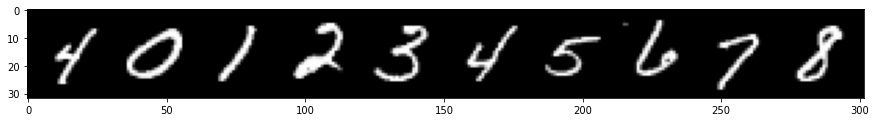

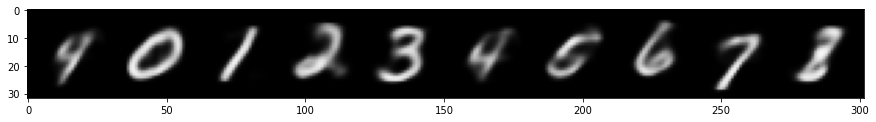

Epoch: 91, loss: 7898950.0
Epoch: 92, loss: 7901266.5
Epoch: 93, loss: 7897172.0
Epoch: 94, loss: 7868428.0
Epoch: 95, loss: 7885868.5
Epoch: 96, loss: 7867848.0
Epoch: 97, loss: 7868782.0
Epoch: 98, loss: 7861638.5
Epoch: 99, loss: 7855791.0
Epoch: 100, loss: 7844463.5


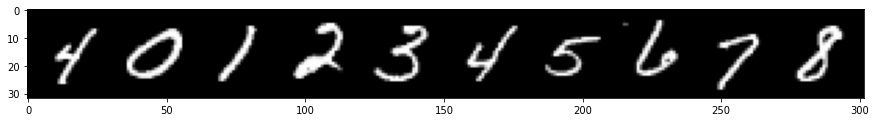

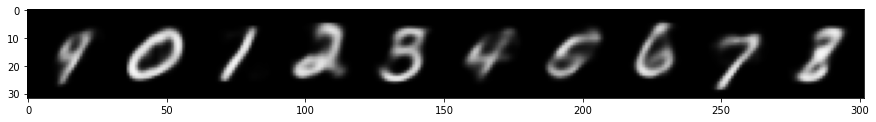

In [166]:
encoder = Encoder(input_size, hidden_size, bottleneck).to(device) # define the encoder
decoder = Decoder(bottleneck, hidden_size, input_size).to(device) # define the decoder
optimizer = opt.Adagrad(list(encoder.parameters()) + list(decoder.parameters()) , lr=stepsize) # define the optimizer

train(encoder, decoder, vae_loss, optimizer, mnist, epochs)

In [167]:
hidden_size = 500
bottleneck = 10
input_size = 784
stepsize = 0.01
epochs = 100
# add the parameters for weight initlization

In [ ]:
encoder = Encoder(input_size, hidden_size, bottleneck).to(device) # define the encoder
decoder = Decoder(bottleneck, hidden_size, input_size).to(device) # define the decoder
optimizer = opt.Adagrad(list(encoder.parameters()) + list(decoder.parameters()) , lr=stepsize) # define the optimizer

train(encoder, decoder, vae_loss, optimizer, mnist, epochs)

Epoch: 1, loss: 10746710.0
Epoch: 2, loss: 9991705.0
Epoch: 3, loss: 9473146.0
